## Calculate the skill of a MJO Index as a function of lead time

### In this example, we demonstrate: 
1. How to remotely access data from the Subseasonal Experiment (SubX) hindcast database and set it up to be used in `climpred`. 
2. How to calculate the Anomaly Correlation Coefficient (ACC) using daily data with `climpred`
3. How to calculate and plot historical forecast skill of the real-time multivariate MJO (RMM) indices as function of lead time.

### The Subseasonal Experiment (SubX)

Further information on SubX is available from [Pegion et al. 2019](https://journals.ametsoc.org/doi/full/10.1175/BAMS-D-18-0270.1) and the [SubX project website](http://cola.gmu.edu/subx/)

The SubX public database is hosted on the International Research Institute for Climate and Society (IRI) data server http://iridl.ldeo.columbia.edu/SOURCES/.Models/.SubX/

Since the SubX data server is accessed via this notebook, the time for the notebook to run may is several minutes and will vary depending on the speed that data can be downloaded. This is a large dataset, so please be patient. If you prefer to download SubX data locally, scripts are available from https://github.com/kpegion/SubX.

### Definitions

RMM
: Two indices (RMM1 and RMM2) are used to represent the MJO.  Together they define the MJO based on 8 phases and can represent both the phase and amplitude of the MJO (Wheeler and Hendon 2004).  This example uses the observed RMM1 provided by Matthew Wheeler at the Center for Australian Weather and Climate Research.  It is the version of the indices in which interannual variability has not been removed.

Skill of RMM
: Traditionally, the skill of the RMM is calculated as a bivariate correlation encompassing the skill of the two indices together (Rashid et al. 2010; Gottschalck et al. 2010).  Currently, `climpred` does not have the functionality to calculate the bivariate correlation, thus the anomaly correlation coefficient for RMM1 index is calculated here as a demonstration.  The bivariate correlation metric will be added in a future version of `climpred`

In [1]:
import warnings

import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import numpy as np

from climpred import HindcastEnsemble
import climpred

In [2]:
warnings.filterwarnings("ignore")

Function to set 360 calendar to 360_day calendar and decond cf times

In [3]:
def decode_cf(ds, time_var):
    if ds[time_var].attrs['calendar'] == '360':
        ds[time_var].attrs['calendar'] = '360_day'
    ds = xr.decode_cf(ds, decode_times=True)
    return ds

Read the observed RMM Indices

In [4]:
obsds = climpred.tutorial.load_dataset('RMM-INTERANN-OBS')['rmm1'].to_dataset()
obsds

<xarray.Dataset>
Dimensions:  (time: 15613)
Coordinates:
  * time     (time) datetime64[ns] 1974-06-03 1974-06-04 ... 2017-07-24
Data variables:
    rmm1     (time) float64 ...

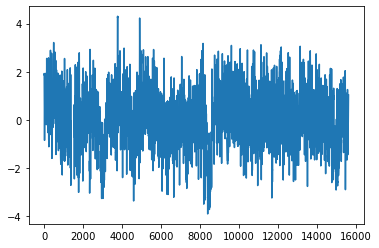

In [5]:
plt.plot(obsds['rmm1'])

Read the SubX RMM1 data for the GMAO-GEOS_V2p1 model from the SubX data server.  It is important to note that the SubX data contains weekly initialized forecasts where the `init` day varies by model.  SubX data may have all NaNs for initial dates in which a model does not make a forecast, thus we apply `dropna` over the `S=init` dimension when `how=all` data for a given `S=init` is missing.  This can be slow, but allows the rest of the calculations to go more quickly. 

In [6]:
url = 'http://iridl.ldeo.columbia.edu/SOURCES/.Models/.SubX/.GMAO/.GEOS_V2p1/.hindcast/.RMM/.RMM1/dods/'
fcstds = xr.open_dataset(url, decode_times=False, chunks={'S': 1, 'L': 45}).dropna(dim='S',how='all')
fcstds

<xarray.Dataset>
Dimensions:  (L: 45, M: 4, S: 510)
Coordinates:
  * S        (S) float32 14245.0 14250.0 14255.0 ... 20439.0 20444.0 20449.0
  * M        (M) float32 1.0 2.0 3.0 4.0
  * L        (L) float32 0.5 1.5 2.5 3.5 4.5 5.5 ... 40.5 41.5 42.5 43.5 44.5
Data variables:
    RMM1     (S, M, L) float32 dask.array<chunksize=(1, 4, 45), meta=np.ndarray>
Attributes:
    Conventions:  IRIDL

The SubX data dimensions correspond to the following `climpred` dimension definitions: `X=lon`,`L=lead`,`Y=lat`,`M=member`, `S=init`.  We will rename the dimensions to their `climpred` names.

In [7]:
fcstds=fcstds.rename({'S': 'init','L': 'lead','M': 'member', 'RMM1' : 'rmm1'})

Let's make sure that the `lead` dimension is set properly for `climpred`.  SubX data stores `leads` as 0.5, 1.5, 2.5, etc, which correspond to 0, 1, 2, ... days since initialization. We will change the `lead` to be integers starting with zero. 

In [8]:
fcstds['lead']=(fcstds['lead']-0.5).astype('int')

Now we need to make sure that the `init` dimension is set properly for `climpred`.  For daily data, the `init` dimension must be a `xr.cfdateTimeIndex` or a `pd.datetimeIndex`.  We convert the `init` values to `pd.datatimeIndex`.

In [9]:
fcstds=decode_cf(fcstds,'init')
fcstds['init']=pd.to_datetime(fcstds.init.values.astype(str))
fcstds['init']=pd.to_datetime(fcstds['init'].dt.strftime('%Y%m%d 00:00'))

`climpred` also requires that `lead` dimension has an attribute called `units` indicating what time units the `lead` is assocated with.  Options are: `years,seasons,months,weeks,pentads,days`.  For the SubX data, the `lead` `units` are `days`. 

In [10]:
fcstds['lead'].attrs={'units': 'days'}

Create the `climpred HindcastEnsemble` object and add the observations as the reference/verification

In [11]:
hindcast = HindcastEnsemble(fcstds)
hindcast=hindcast.add_reference(obsds, 'observations')

Calculate the Anomaly Correlation Coefficient (ACC)

In [12]:
skill = hindcast.compute_metric(metric='acc')

Plot the skill as a function of lead time

Text(0, 0.5, 'ACC')

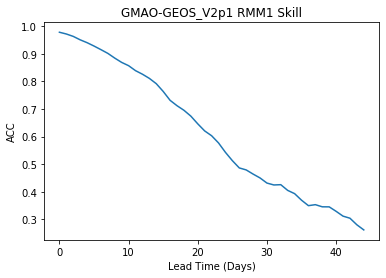

In [13]:
plt.plot(skill['rmm1'])
plt.title('GMAO-GEOS_V2p1 RMM1 Skill')
plt.xlabel('Lead Time (Days)')
plt.ylabel('ACC')

### References

1. Pegion, K., B.P. Kirtman, E. Becker, D.C. Collins, E. LaJoie, R. Burgman, R. Bell, T. DelSole, D. Min, Y. Zhu, W. Li, E. Sinsky, H. Guan, J. Gottschalck, E.J. Metzger, N.P. Barton, D. Achuthavarier, J. Marshak, R.D. Koster, H. Lin, N. Gagnon, M. Bell, M.K. Tippett, A.W. Robertson, S. Sun, S.G. Benjamin, B.W. Green, R. Bleck, and H. Kim, 2019: The Subseasonal Experiment (SubX): A Multimodel Subseasonal Prediction Experiment. Bull. Amer. Meteor. Soc., 100, 2043–2060, https://doi.org/10.1175/BAMS-D-18-0270.1

2. Kirtman, B. P., Pegion, K., DelSole, T., Tippett, M., Robertson, A. W., Bell, M., … Green, B. W. (2017). The Subseasonal Experiment (SubX) [Data set]. IRI Data Library. https://doi.org/10.7916/D8PG249H

3. Wheeler, M. C., & (null), H. H. (2004). An all-season real-time multivariate MJO index: Development of an index for monitoring and prediction. Monthly Weather Review, 132(8), 1917–1932. http://doi.org/10.1175/1520-0493(2004)132

4. Rashid, H. A., Hendon, H. H., Wheeler, M. C., & Alves, O. (2010). Prediction of the Madden–Julian oscillation with the POAMA dynamical prediction system. Climate Dynamics, 36(3-4), 649–661. http://doi.org/10.1007/s00382-010-0754-x

5. Gottschalck, J., Wheeler, M., Weickmann, K., Vitart, F., Savage, N., Lin, H., et al. (2010). A Framework for Assessing Operational Madden–Julian Oscillation Forecasts: A CLIVAR MJO Working Group Project. Bulletin of the American Meteorological Society, 91(9), 1247–1258. http://doi.org/10.1175/2010BAMS2816.1